# Cleaning Data/EDA

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn
from sklearn.linear_model import LinearRegression, LassoCV, RidgeCV
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict
from sklearn.metrics import r2_score, mean_squared_error


%matplotlib inline

In [2]:
train = pd.read_csv('../datasets/train.csv')#,index_col=0)
test = pd.read_csv('../datasets/test.csv')#, index_col=0)

In [3]:
train.head()

,Id,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,...,Screen Porch,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type,SalePrice
0,109,533352170,60,RL,NaN,13517,Pave,NaN,IR1,Lvl,...,0,0,NaN,NaN,NaN,0,3,2010,WD,130500
1,544,531379050,60,RL,43.0,11492,Pave,NaN,IR1,Lvl,...,0,0,NaN,NaN,NaN,0,4,2009,WD,220000
2,153,535304180,20,RL,68.0,7922,Pave,NaN,Reg,Lvl,...,0,0,NaN,NaN,NaN,0,1,2010,WD,109000
3,318,916386060,60,RL,73.0,9802,Pave,NaN,Reg,Lvl,...,0,0,NaN,NaN,NaN,0,4,2010,WD,174000
4,255,906425045,50,RL,82.0,14235,Pave,NaN,IR1,Lvl,...,0,0,NaN,NaN,NaN,0,3,2010,WD,138500


In [4]:
def noval(col):
    print((col).isnull().sum())

In [5]:
noval(train['Lot Frontage'])

330


In [6]:
train['Lot Frontage'].fillna(0, inplace=True)
#filling NA's in this numerical column with 0

In [7]:
noval(train['Lot Area'])

0


In [8]:
train['Alley'].fillna('No Access', inplace=True)
train['Alley'].value_counts()
#data description states "NA" values indicate no alley access, so I replace those blanks with "No Access"

No Access    1911
Grvl           85
Pave           55
Name: Alley, dtype: int64

In [9]:
train['Condition 2'].value_counts()

Norm      2025
Feedr       11
Artery       5
PosN         3
PosA         3
RRNn         2
RRAe         1
RRAn         1
Name: Condition 2, dtype: int64

In [10]:
train['Conditions']= train['Condition 1'].str.cat(train['Condition 2'], sep=",")
#Condition 1 and Condition 2 deal with the same values; I combined into one column (separating vals with a comma) for ease/to prevent future high multicollinearity

In [11]:
train.drop(['Condition 1', 'Condition 2'], axis=1, inplace=True)

In [12]:
noval(train['Mas Vnr Type'])

22


In [13]:
noval(train['Mas Vnr Area'])

22


In [14]:
#making sure the 22 null rows match up with respective columns;
#rather than get rid of them, I'll replace them with relevant assumed values
(train[train['Mas Vnr Type'].isnull()]).index & (train[train['Mas Vnr Area'].isnull()]).index

Int64Index([  22,   41,   86,  212,  276,  338,  431,  451,  591,  844,  913,
             939, 1025, 1244, 1306, 1430, 1434, 1606, 1699, 1815, 1820, 1941],
           dtype='int64')

In [15]:
train['Mas Vnr Type'].fillna('None', inplace=True)
train['Mas Vnr Area'].fillna(0, inplace=True)

In [16]:
(train[train['Bsmt Cond'].isnull()].index) & (train[train['Bsmt Qual'].isnull()].index) & (train[train['Bsmt Exposure'].isnull()].index)

Int64Index([  12,   93,  114,  146,  183,  240,  249,  256,  390,  437,  485,
             499,  514,  580,  581,  616,  635,  642,  696,  700,  737,  772,
             790,  794,  924,  933,  954, 1007, 1022, 1049, 1089, 1098, 1125,
            1157, 1211, 1222, 1252, 1256, 1270, 1327, 1331, 1377, 1387, 1428,
            1481, 1594, 1620, 1681, 1684, 1686, 1859, 1875, 1889, 1933, 2010],
           dtype='int64')

In [17]:
#there are more null vals in 'Bsmt Exposure'
#after identifying indexes that do not match; replacing those appropriately
(train[train['Bsmt Exposure'].isnull()].index)

Int64Index([  12,   93,  114,  146,  183,  240,  249,  256,  390,  437,  485,
             499,  514,  580,  581,  616,  635,  642,  696,  700,  737,  772,
             790,  794,  924,  933,  954, 1007, 1022, 1049, 1089, 1098, 1125,
            1157, 1211, 1222, 1252, 1256, 1270, 1327, 1331, 1377, 1387, 1428,
            1456, 1481, 1547, 1594, 1620, 1681, 1684, 1686, 1859, 1875, 1889,
            1933, 1997, 2010],
           dtype='int64')

In [18]:
train.loc[1997, 'Bsmt Exposure']='No'
train.loc[1547, 'Bsmt Exposure']='No'
train.loc[1456, 'Bsmt Exposure']='No'

In [19]:
#'NB' for no basement
train['Bsmt Qual'].fillna('NB', inplace=True)
train['Bsmt Cond'].fillna('NB', inplace=True)
train['Bsmt Exposure'].fillna('NB', inplace=True)

In [20]:
train['BsmtFin Type 1'].fillna('NB', inplace=True)

In [21]:
train['BsmtFin SF 1'].fillna(0, inplace=True)

In [22]:
train['BsmtFin Type 2'].fillna('NB', inplace=True)

In [23]:
train['BsmtFin SF 2'].fillna(0, inplace=True)

In [24]:
train['Bsmt Unf SF'].fillna(0, inplace=True)

In [25]:
train['BsmtFin SF'] = train['BsmtFin SF 1'] + train['BsmtFin SF 2']

In [26]:
#rename to match pattern of other basement names/easier to call
train.rename(columns ={'Total Bsmt SF': 'Bsmt Total SF'}, inplace=True)
train['Bsmt Total SF'].fillna(0, inplace=True)

In [27]:
train[train['Bsmt Full Bath'].isnull()].index

Int64Index([616, 1327], dtype='int64')

In [28]:
train[train['Bsmt Half Bath'].isnull()].index

Int64Index([616, 1327], dtype='int64')

In [29]:
train['Bsmt Half Bath'].fillna(0, inplace=True)
train['Bsmt Full Bath'].fillna(0, inplace=True)

In [30]:
train['Bsmt Total Baths'] = train['Bsmt Full Bath'] + train['Bsmt Half Bath']

In [31]:
train.drop('Bsmt Full Bath',axis=1, inplace=True)
train.drop('Bsmt Half Bath', axis=1,inplace=True)

In [32]:
train['Total Baths'] = train['Full Bath'] + train['Half Bath']

In [33]:
#another instance where data descr uses NA to mean no
train['Fireplace Qu'].fillna('NFP', inplace=True)

In [34]:
train['Fireplaces*Fireplace Quality '] = train['Fireplaces']*train['Fireplace Qu']

In [35]:
train.drop('Fireplaces',axis=1,inplace=True)
train.drop('Fireplace Qu', axis=1,inplace=True)

In [36]:
#Na = no garage
train['Garage Type'].fillna('NG',inplace=True)

In [37]:
train['Garage Yr Blt'].fillna(0,inplace=True)

In [38]:
train['Garage Finish'].fillna('NG',inplace=True)

In [39]:
train[train['Garage Cars'].isnull()].index

Int64Index([1712], dtype='int64')

In [40]:
#The null value in 'garage cars' corresponds to a instance where 'garage type' is full but other garage variables are also empty
#Therefore, I am dropping the row
train.drop(train.index[1712], inplace=True)

In [41]:
train['Garage Qual'].fillna('NG', inplace=True)

In [42]:
train['Garage Cond'].fillna('NG', inplace=True)

In [43]:
#NAs in 'Pool Qual' correspond with 0's in Pool sq ft; therefore, filling as 'NP', no pool

In [44]:
train['Pool QC'].fillna('NP', inplace=True)

In [45]:
train['Fence'].fillna('NF', inplace=True)

In [46]:
train['Misc Feature'].fillna('None', inplace=True)

In [47]:
train['Mo/Yr Sold']= (train['Mo Sold'].map(str)).str.cat((train['Yr Sold'].map(str)), sep="-")


In [48]:
train.drop('Mo Sold', axis=1, inplace=True)

In [49]:
train.loc[1699]['Garage Yr Blt']
#Garage could not have been built in a year that has yet to occur; removing

2207.0

In [50]:
train.drop([1699], axis=0, inplace=True)

In [51]:
#creating an interaction term of these two closely related variables
train['Overall Quality Score'] = train['Overall Qual']*train['Overall Cond']

In [52]:
train['Exterior Covering'] = (train['Exterior 1st']).str.cat((train['Exterior 2nd']), sep='&')

In [53]:
train['Exterior Quality Score'] = (train['Exter Qual'].replace(['Ex', 'Gd','TA','Fa','Po'], [5,4,3,2,1]))*(train['Exter Cond'].replace(['Ex', 'Gd','TA','Fa','Po'], [5,4,3,2,1]))

In [54]:
train.drop('Exter Qual', axis=1, inplace=True)
train.drop('Exter Cond', axis=1,inplace=True)

In [55]:
train['BsmtFin Quality Score'] = (train['BsmtFin Type 1'].replace(['GLQ','ALQ','BLQ','Rec','LwQ', 'Unf','NB'],[6,5,4,3,2,1,0]))*(train['BsmtFin Type 2'].replace(['GLQ','ALQ','BLQ','Rec','LwQ', 'Unf','NB'],[6,5,4,3,2,1,0]))

In [56]:
train.drop('BsmtFin Type 1', axis=1,inplace=True)
train.drop('BsmtFin Type 2', axis=1, inplace=True)

# Plots to identify correlations and outliers & decide on course of action

In [57]:
train.describe()

,Id,PID,MS SubClass,Lot Frontage,Lot Area,Overall Qual,Overall Cond,Year Built,Year Remod/Add,Mas Vnr Area,...,Screen Porch,Pool Area,Misc Val,Yr Sold,SalePrice,BsmtFin SF,Bsmt Total Baths,Total Baths,Overall Quality Score,BsmtFin Quality Score
count,2049.000000,2.049000e+03,2049.000000,2049.000000,2049.000000,2049.000000,2049.000000,2049.000000,2049.000000,2049.000000,...,2049.000000,2049.000000,2049.000000,2049.000000,2049.000000,2049.000000,2049.000000,2049.000000,2049.000000,2049.000000
mean,1473.277208,7.133951e+08,57.020498,57.943387,10066.561249,6.111762,5.562225,1971.715959,1984.171791,98.722792,...,16.527574,2.400195,51.624695,2007.776476,181442.727672,489.946803,0.490971,1.948267,33.865300,4.764763
std,844.045057,1.886806e+08,42.836359,33.152299,6745.630603,1.426145,1.104924,30.163913,21.037930,174.382527,...,57.399890,37.800940,573.671628,1.312430,79271.785228,482.194499,0.545795,0.798716,9.258991,4.584100
min,1.000000,5.263011e+08,20.000000,0.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,...,0.000000,0.000000,0.000000,2006.000000,12789.000000,0.000000,0.000000,0.000000,1.000000,0.000000
25%,753.000000,5.284581e+08,20.000000,43.000000,7500.000000,5.000000,5.000000,1954.000000,1964.000000,0.000000,...,0.000000,0.000000,0.000000,2007.000000,129800.000000,0.000000,0.000000,1.000000,30.000000,1.000000
50%,1481.000000,5.354532e+08,50.000000,63.000000,9434.000000,6.000000,5.000000,1974.000000,1993.000000,0.000000,...,0.000000,0.000000,0.000000,2008.000000,162500.000000,454.000000,0.000000,2.000000,35.000000,5.000000
75%,2195.000000,9.071760e+08,70.000000,78.000000,11515.000000,7.000000,6.000000,2001.000000,2004.000000,160.000000,...,0.000000,0.000000,0.000000,2009.000000,214000.000000,794.000000,1.000000,3.000000,40.000000,6.000000
max,2930.000000,9.241520e+08,190.000000,313.000000,159000.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,...,490.000000,800.000000,17000.000000,2010.000000,611657.000000,5644.000000,3.000000,6.000000,90.000000,30.000000


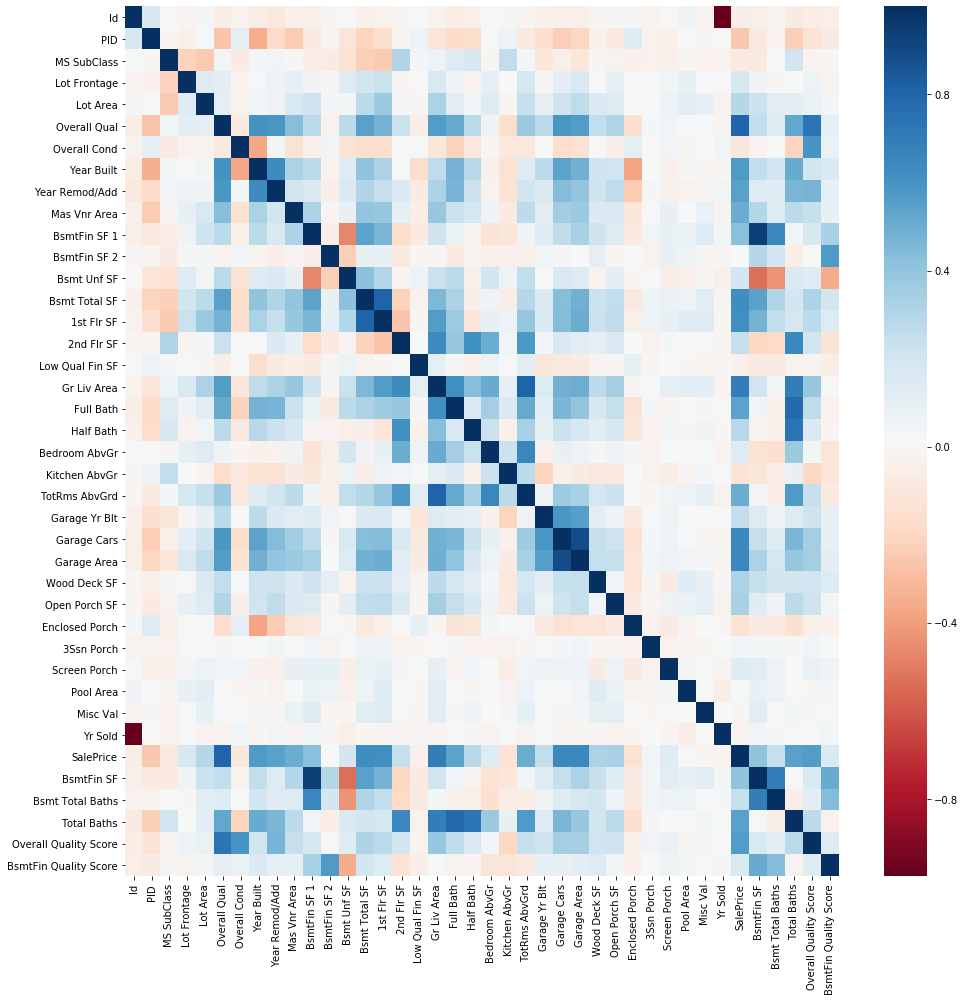

In [58]:
plt.figure(figsize= (16,16))
sns.heatmap(train.corr(),cmap='RdBu');

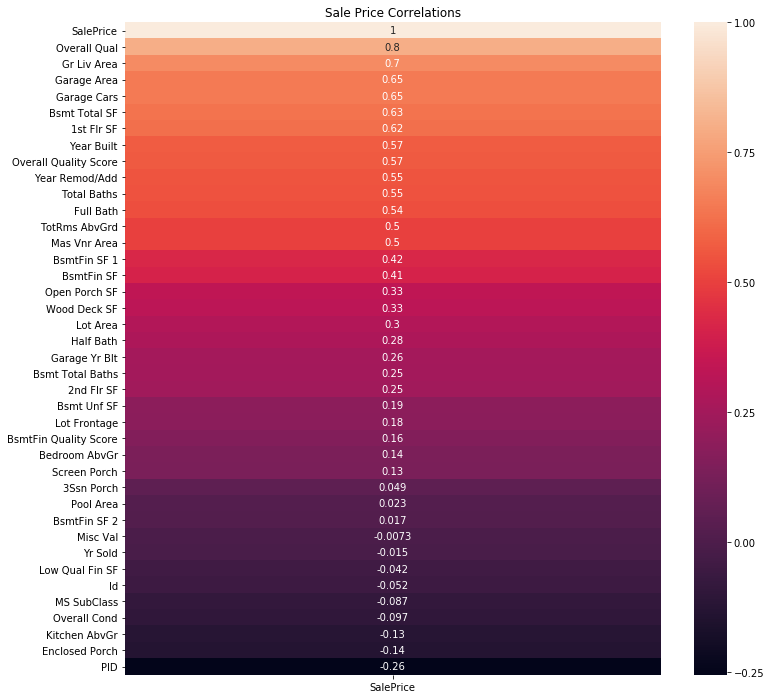

In [59]:
plt.figure(figsize=(12,12))
sns.heatmap((train.corr()[['SalePrice']]).sort_values('SalePrice', ascending=False), annot=True) #sourced from code written by Mahdi S.
plt.title('Sale Price Correlations');

#### From the above heatmaps, we can see which variables are most closely correlated with sale price and each other:
                                 * Overall Quality
                                 * Gr Liv Area (Above Ground Living Area SF)
                                 * Garage Cars/Garage Area
                                 * 1st Fl SF
                                 * Bsmt Total SF
                                 * Full Baths

With this information, I can identify other variables correlated with these to expand/play around with the variables of my models.

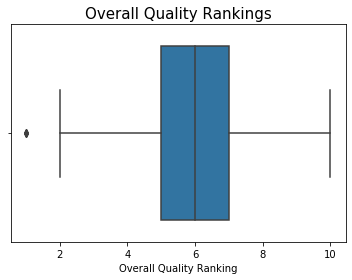

In [60]:
sns.boxplot(train['Overall Qual'])
plt.title('Overall Quality Rankings', size=15)
plt.xlabel('Overall Quality Ranking');

The clear outliers here are properties with overall quality values below 2. <br>
There are only 4 instances of these super low scores. <br> Therefore, I think it is prudent to remove these as they may unnecessarily skew my model results.

In [61]:
train['Overall Qual'].value_counts()

5     562
6     506
7     431
8     249
4     159
9      77
3      29
10     23
2       9
1       4
Name: Overall Qual, dtype: int64

In [62]:
train = train[train['Overall Qual'] != 1]

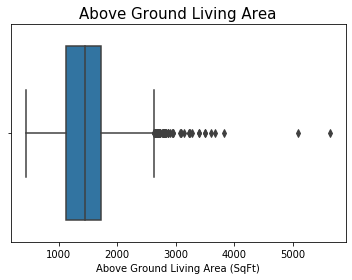

In [63]:
sns.boxplot(train['Gr Liv Area'])
plt.title('Above Ground Living Area', size=15)
plt.xlabel('Above Ground Living Area (SqFt)');

In [64]:
(train['Gr Liv Area']>=3000).value_counts()

False    2028
True       17
Name: Gr Liv Area, dtype: int64

Homes with an above ground living area square footage of over 3000sqft represent less than 1% of all homes. <br>
Rather than remove them, I will create a separate column for these 'larger area' homes.

In [65]:
train['Larger Gr Liv Area'] = ((train['Gr Liv Area']>=3000)==True)

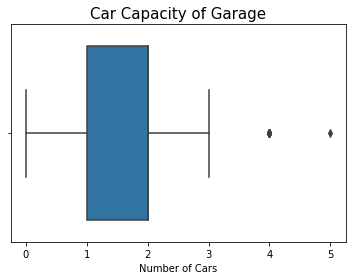

In [66]:
sns.boxplot(train['Garage Cars'])
plt.title('Car Capacity of Garage', size=15)
plt.xlabel('Number of Cars');

The clear outliers here are garages with car capacities of 4 & 5. <br> There is only 1 garage that accomodates 5 cars, and it does not fall into the 'Larger Gr Living Area' column (as would be expected as ground living area sqft and garage car capacities are otherwise correlated columns). <br> 
We can conclude it is an anomaly and not of benefit to my models. It will be removed.

In [67]:
train['Garage Cars'].value_counts()

2.0    1134
1.0     523
3.0     263
0.0     111
4.0      13
5.0       1
Name: Garage Cars, dtype: int64

In [68]:
train = train[train['Garage Cars'] != 5]

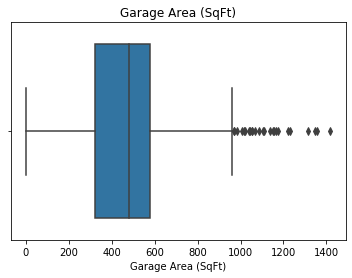

In [69]:
sns.boxplot(train['Garage Area'])
plt.title('Garage Area (SqFt)')
plt.xlabel('Garage Area (SqFt)');

Homes with garage areas over 1000 SqFt are rare, and only 1 contains a garage over 1400, an anomaly. <br> I will drop this row.

In [70]:
(train['Garage Area']>1000).value_counts()

False    2022
True       22
Name: Garage Area, dtype: int64

In [71]:
(train[train['Garage Area']>1400]).index

Int64Index([960], dtype='int64')

In [72]:
train.drop([960],inplace=True)

Due to the clear relationship between the 'Garage Area' & 'Garage Cars' columns, I will create an interaction term of the two.

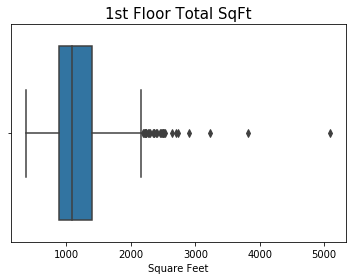

In [73]:
sns.boxplot(train['1st Flr SF'])
plt.title('1st Floor Total SqFt', size=15)
plt.xlabel('Square Feet');

Of these outlier home sizes, there is only one home with a square footage over 5000 , one home with a square footage over 4000 , and one with a square footage over 3000. <br> These I will remove from my dataset. <br>The homes with square footage over 2000 mostly also appear in the variable 'Larger Gr Liv Area' I created to represent homes with an overall sqft living area over the max 3000.

In [74]:
(train['1st Flr SF']>2000).value_counts()

False    1990
True       53
Name: 1st Flr SF, dtype: int64

In [75]:
(train[(train['1st Flr SF']>2000) & (train['Larger Gr Liv Area']==True)])

,Id,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,...,BsmtFin SF,Bsmt Total Baths,Total Baths,Fireplaces*Fireplace Quality,Mo/Yr Sold,Overall Quality Score,Exterior Covering,Exterior Quality Score,BsmtFin Quality Score,Larger Gr Liv Area
328,1773,528366050,20,RL,0.0,12692,Pave,No Access,IR1,Lvl,...,1231.0,1.0,3,Gd,5-2007,40,BrkFace&BrkFace,12,6,True
616,1498,908154080,20,RL,123.0,47007,Pave,No Access,IR1,Lvl,...,0.0,0.0,4,GdGd,7-2008,35,Plywood&Plywood,9,0,True
1389,66,528386040,50,RL,56.0,14720,Pave,No Access,IR1,Lvl,...,816.0,1.0,3,Ex,3-2010,40,VinylSd&VinylSd,12,6,True
1885,2181,908154195,20,RL,128.0,39290,Pave,No Access,IR1,Bnk,...,4010.0,2.0,3,GdGd,10-2007,50,CemntBd&CmentBd,15,6,True


In [76]:
train = train[train['1st Flr SF'] <3000]

Text(0.5, 0, 'Square Feet')

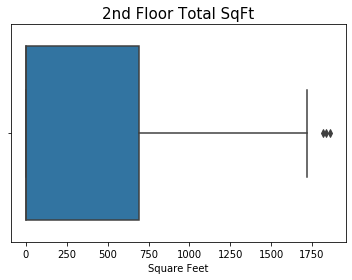

In [77]:
sns.boxplot(train['2nd Flr SF'])
plt.title('2nd Floor Total SqFt', size=15)
plt.xlabel('Square Feet')

There are 3 outliers here. Homes whose second floor square footage exceeds 1800. Because these 3 match up with homes in my category for larger than avg above ground living area, I will keep them.

In [78]:
(train['2nd Flr SF']>1800).value_counts()

False    2037
True        3
Name: 2nd Flr SF, dtype: int64

In [79]:
(train[(train['2nd Flr SF']>1800) & (train['Larger Gr Liv Area']==True)])

,Id,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,...,BsmtFin SF,Bsmt Total Baths,Total Baths,Fireplaces*Fireplace Quality,Mo/Yr Sold,Overall Quality Score,Exterior Covering,Exterior Quality Score,BsmtFin Quality Score,Larger Gr Liv Area
138,2331,527210040,60,RL,60.0,18062,Pave,No Access,IR1,HLS,...,0.0,0.0,4,Ex,9-2006,50,CemntBd&CmentBd,15,1,True
1897,2738,905427030,75,RL,60.0,19800,Pave,No Access,Reg,Lvl,...,425.0,0.0,4,GdGd,12-2006,48,BrkFace&Wd Sdng,9,3,True
1939,1307,902207220,75,RM,87.0,18386,Pave,No Access,Reg,Lvl,...,0.0,0.0,3,Ex,5-2008,63,CemntBd&CmentBd,9,1,True


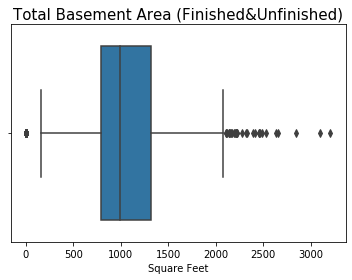

In [80]:
sns.boxplot(train['Bsmt Total SF'])
plt.title('Total Basement Area (Finished&Unfinished)', size=15)
plt.xlabel('Square Feet');

There are only 2 houses wherein the total SF of the basement is greater than 3000. <br>
I am creating a new column that uses 1 to denote if a house's finished square footage is greater than half of the total basement square footage (0 if not). <br>
My assumption is that because total basement sq footage is positively correlated with sale price, the larger the basement, the more the house is worth; the more finished square footage of the basement, the higher the sale price.

In [81]:
LgFin = []
for index, row in train.iterrows():
    if (row['BsmtFin SF 1']+ row['BsmtFin SF 2'])>(row['Bsmt Total SF']/2):
        LgFin.append(1)
    else:
        LgFin.append(0)

In [82]:
train['Over 50%Fin Bsmt'] = LgFin

In [83]:
train['BsmtFin SF'] = train['BsmtFin SF 1'] + train['BsmtFin SF 2']

In [84]:
train.drop(['PID'], axis=1, inplace=True)

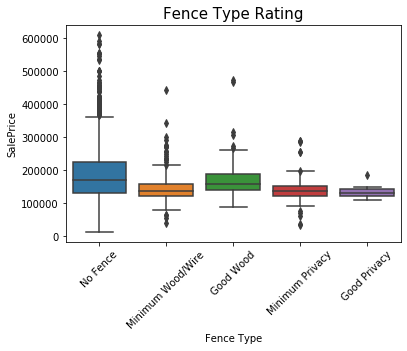

In [85]:
g = sns.boxplot(train['Fence'], train['SalePrice'])
flabels = ['No Fence', 'Minimum Wood/Wire','Good Wood','Minimum Privacy','Good Privacy']
g.set_xticklabels(flabels,rotation=45)
plt.title('Fence Type Rating', size=15)
plt.xlabel('Fence Type');

In [86]:
#Because I would like to use fence - or at least determine if it is worth using - in my model, I am converting the categ. values into numbers
train['Fence'] = train['Fence'].replace(['NF','MnWw','GdWo','MnPrv','GdPrv'], [0,1,2,3,4])

#### My instinct is that, as with most places, neighborhood is a large factor in determining the value/"sell-ability" of a home. <br> Let's check this out.

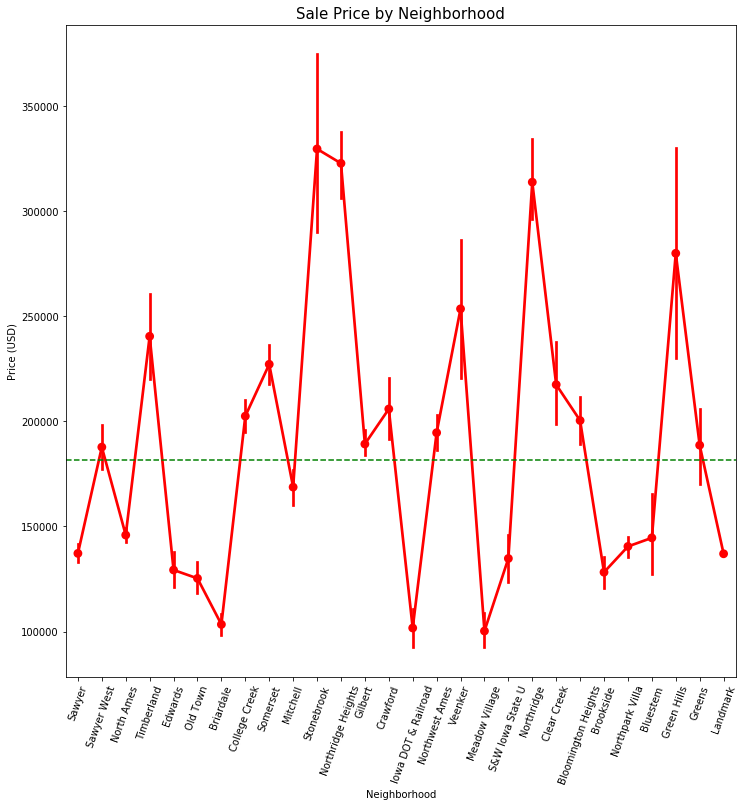

In [87]:
plt.figure(figsize=(12,12))
g = sns.pointplot(x=train['Neighborhood'], y=train['SalePrice'], data=train, color='red')
labels=['Sawyer','Sawyer West',
        'North Ames',
        'Timberland',
        'Edwards', 
        'Old Town', 
        'Briardale',
        'College Creek', 
        'Somerset',
        'Mitchell',
        'Stonebrook',
        'Northridge Heights',
        'Gilbert',
        'Crawford',
        'Iowa DOT & Railroad',
        'Northwest Ames',
        'Veenker',
        'Meadow Village',
        'S&W Iowa State U',
        'Northridge',
        'Clear Creek', 
        'Bloomington Heights', 
        'Brookside', 
        'Northpark Villa', 
        'Bluestem', 
        'Green Hills', 
        'Greens', 
        'Landmark']
g.set_xticklabels(labels,rotation=70)
plt.title('Sale Price by Neighborhood', size=15)
plt.ylabel('Price (USD)')
plt.xlabel('Neighborhood')
mean= train['SalePrice'].mean()
plt.axhline(mean, color='green', linestyle='--');

The above graph shows sale price of homes by the neighborhood in which they are located. The green line represents the average price of a home sold in Ames.

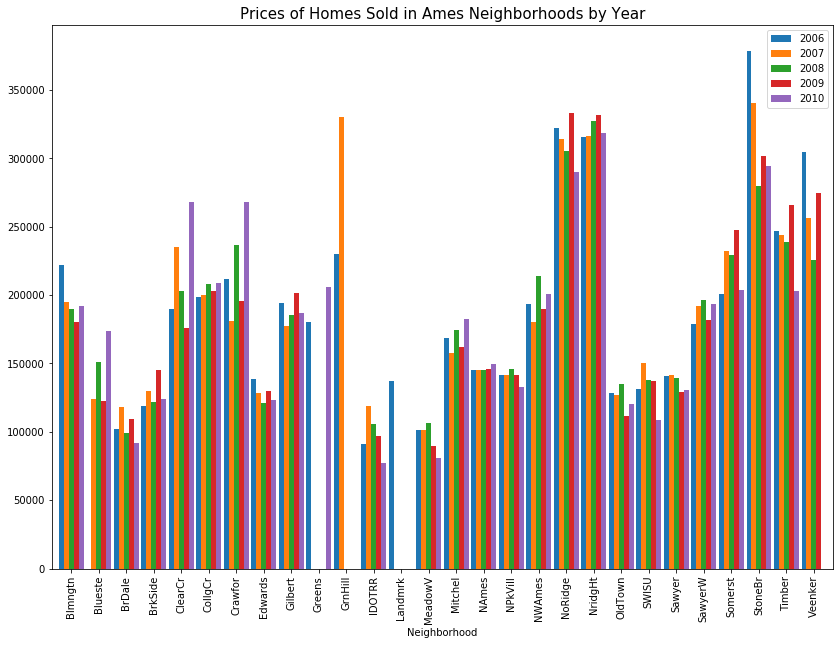

In [88]:
ax = pd.pivot_table(train, index=['Neighborhood'], values=['SalePrice'], columns = ['Yr Sold']).plot(kind='bar', width = .9, figsize=(14,10))
ax.set_xlabel('Neighborhood')
ax.set_title('Prices of Homes Sold in Ames Neighborhoods by Year', fontsize=15)
ax.legend(labels=['2006','2007','2008','2009','2010']);

Above, the price of homes sold by neighborhood for each year the data is available.<br> 
Below, the number of homes sold by neighborhood for each year the data is available.

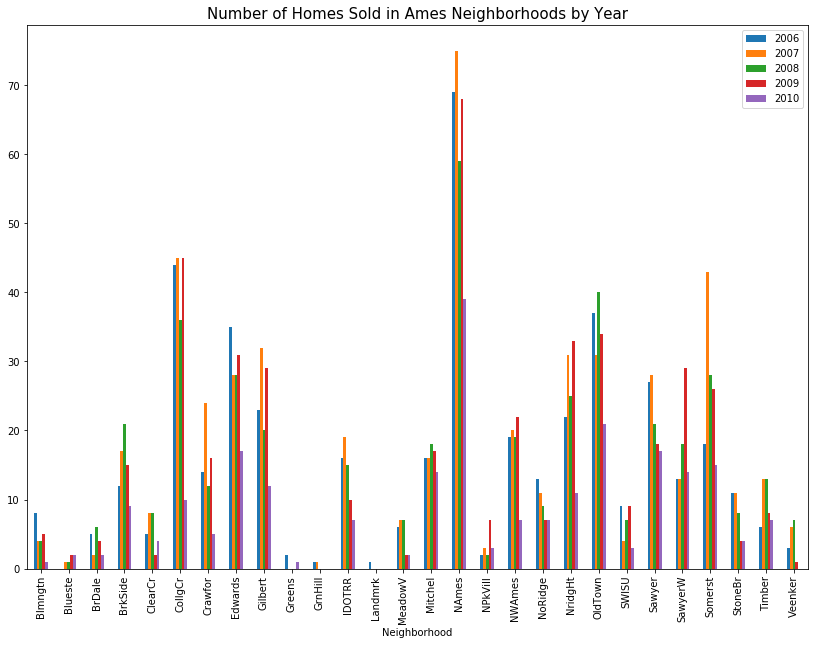

In [89]:
ax = pd.pivot_table(train, index=['Neighborhood'], values=['SalePrice'], columns = ['Yr Sold'], aggfunc=[len]).plot(kind='bar', figsize=(14,10))
ax.set_xlabel('Neighborhood')
ax.set_title('Number of Homes Sold in Ames Neighborhoods by Year', fontsize=15)
ax.legend(labels=['2006','2007','2008','2009','2010']);

While more homes were sold in the North Ames neighborhood, they were not necessarily the highest sale prices. <br> The Northridge, Northridge Heights, Green Hills, and Stonebrook neighborhoods had the highest priced homes sold.<br>
Aside: Home sales in Green Hills were conspicuously low/absent for years after 2007 (recall the recession hit in 2008).

My interest in this variable has been piqued. In order to use it in my Linear Regression model, I am going to convert the data in numerical dummy columns.

In [90]:
dummies = pd.get_dummies(train['Neighborhood'])

In [91]:
train = pd.concat([train, dummies], axis=1)
train.head(1)

,Id,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,Utilities,...,NoRidge,NridgHt,OldTown,SWISU,Sawyer,SawyerW,Somerst,StoneBr,Timber,Veenker
0,109,60,RL,0.0,13517,Pave,No Access,IR1,Lvl,AllPub,...,0,0,0,0,1,0,0,0,0,0


In [92]:
train.drop('Neighborhood', axis=1,inplace=True)

#### Saving my cleaned data to a new csv

In [93]:
train.to_csv('../datasets/cleaned_training_data.csv')

### A revised sale price corr heatmap with my cleaned data

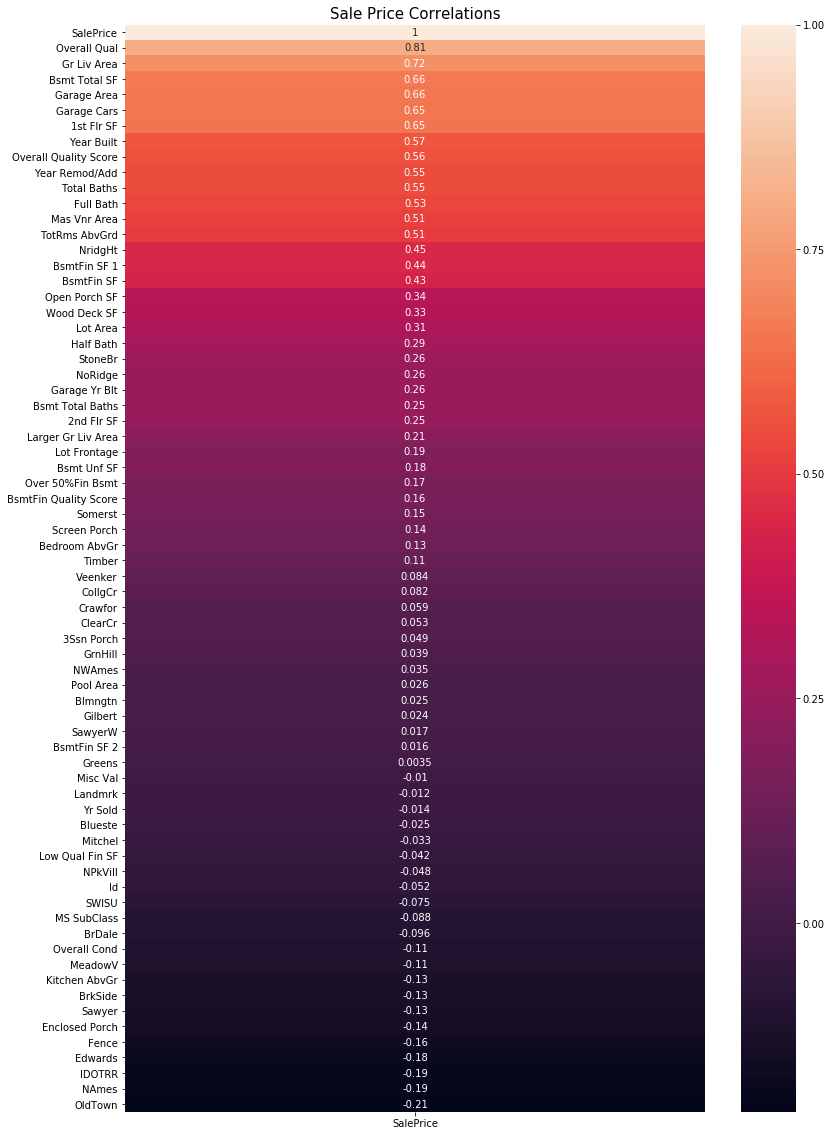

In [94]:

plt.figure(figsize=(13,20))
sns.heatmap((train.corr()[['SalePrice']]).sort_values('SalePrice', ascending=False), annot=True)
plt.title('Sale Price Correlations', size=15);

#### A revised total heatmap with my cleaned data

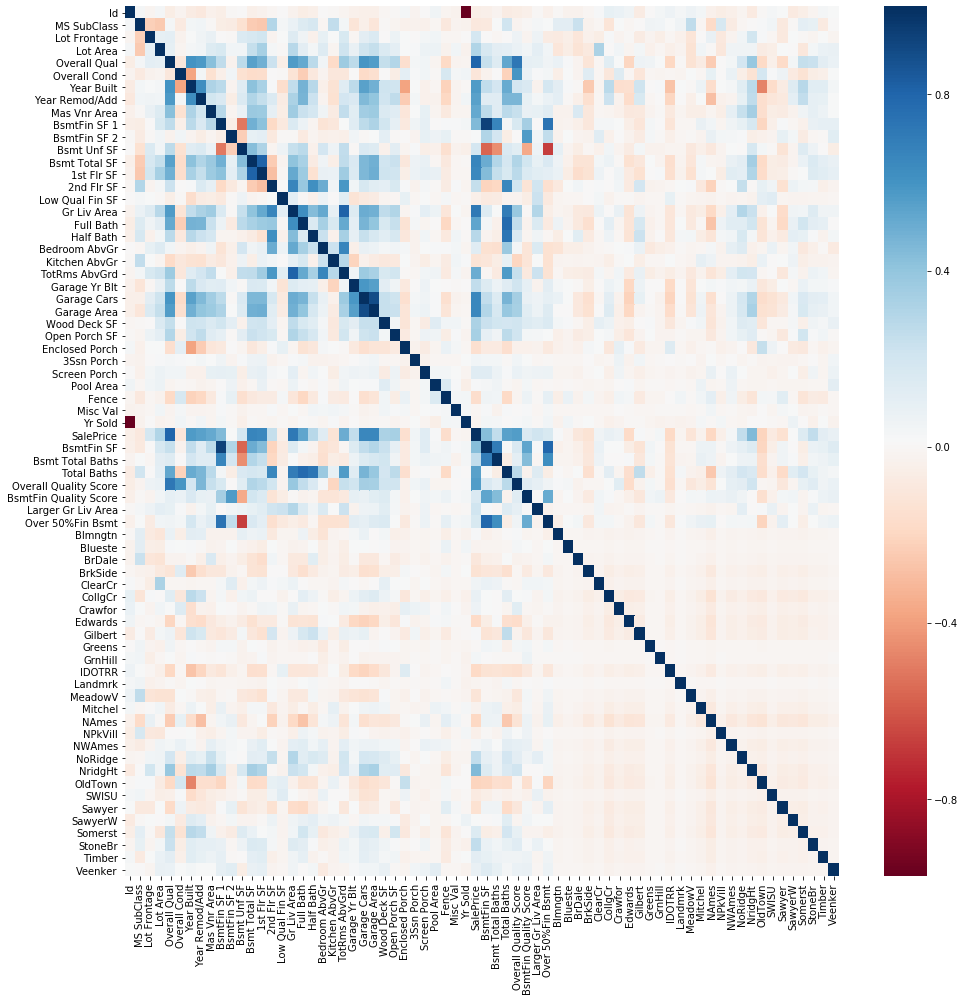

In [95]:
plt.figure(figsize= (16,16))
sns.heatmap(train.corr(),cmap='RdBu');

Though this neighborhood transformation has added 28 new variables to my list of possible features, this only prompts more selectivity in what other variables will be used in my analysis modeling.

In [96]:
#will run when I have more time; takes forever
#sns.pairplot(train)

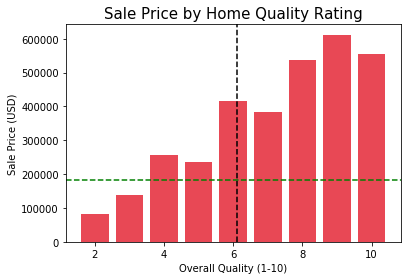

In [97]:
plt.bar(train['Overall Qual'], train['SalePrice'] , color='#E84855')
plt.ylabel('Sale Price (USD)')
plt.xlabel('Overall Quality (1-10)')
plt.title('Sale Price by Home Quality Rating', size=15)
mean = train['Overall Qual'].mean()
smean = train['SalePrice'].mean()
plt.axvline(mean, color='black', linestyle='--')
plt.axhline(smean, color = 'green', linestyle='--');

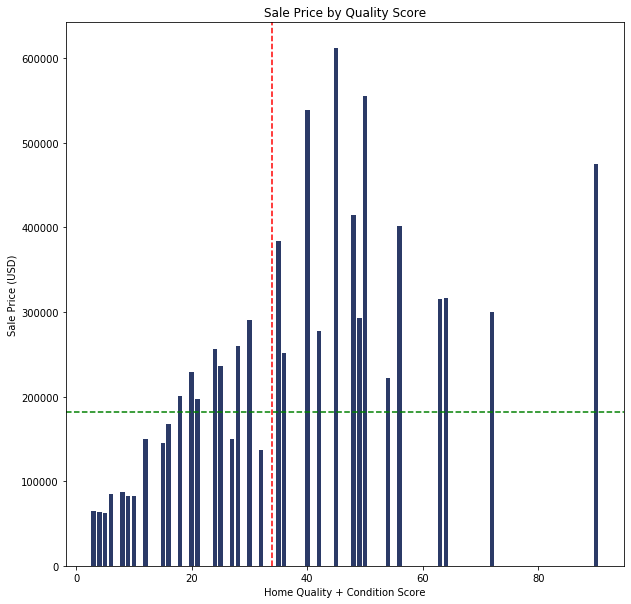

In [98]:
plt.figure(figsize=(10,10))
plt.bar(train['Overall Quality Score'], train['SalePrice'] , color='#2B3A67')
plt.ylabel('Sale Price (USD)')
plt.xlabel('Home Quality + Condition Score')
plt.title('Sale Price by Quality Score')
mean = train['Overall Quality Score'].mean()
smean = train['SalePrice'].mean()
plt.axhline(smean, color = 'green', linestyle='--')
plt.axvline(mean, color='red', linestyle='--');

# Next Steps

### After cleaning my data and performing the necessary functions on variables, I am ready to begin creating and testing out a few models.

### I have chosen to:
                    * combine columns with similar or highly related variables
                    * eliminate outliers that appeared in quantities under 10
                    * keep outliers that appeared in quantities over 10 because eliminating too many outliers may cause one or multiple iterations of my model to be overfit later on
                    * create new columns for outlier variables I think will be significant in determining my target later
                    

In [99]:
train.shape

(2040, 108)

In [100]:
#reordering so that my target column is the last one in my dataframe

#cols = list(train.columns.values)
#cols.pop(cols.index('SalePrice')) 
#train = train[cols+['SalePrice']]

In [101]:
#def scatterem(df, y):
    #for col in range (0,3):
        #fig, axs = plt.subplots()
        #axs.scatter(df.iloc[:,col],y)
    #return fig,ax

In [102]:
#scatterem(train, train['SalePrice'])

In [103]:
train['SalePrice'].mean()

181566.76421568627

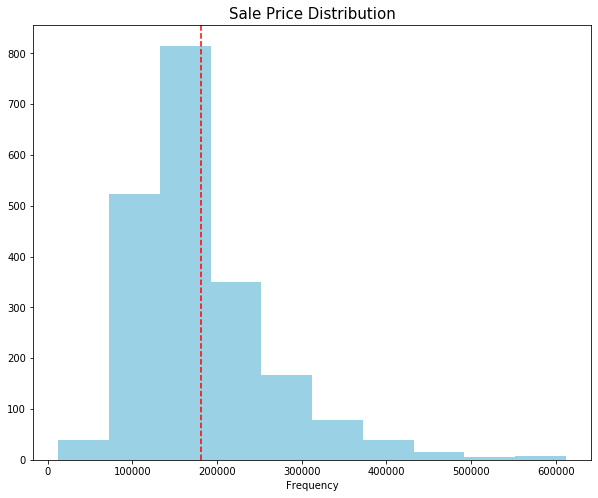

In [104]:
plt.figure(figsize=(10,8))
plt.hist(train['SalePrice'], color = '#9BD1E5')
plt.title('Sale Price Distribution', size=15)
plt.xlabel('Sale Price (USD)')
plt.xlabel('Frequency')
plt.axvline((train['SalePrice'].mean()), color='red', linestyle='--');

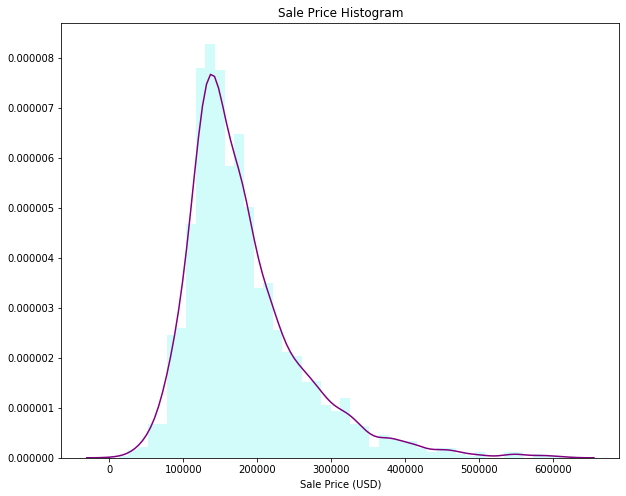

In [105]:
plt.figure(figsize=(10,8))
ax = sns.distplot(train['SalePrice'], color='#8EF9F3', kde_kws={"color": "purple"})
ax.set_xlabel('Sale Price (USD)')
ax.set_title('Sale Price Histogram')
plt.show()

# Preprocessing

#### Feature Selection:
Considering my train dataset still contains 82 variables, utilizing all of them will make my model severely prone to overfitting.<br> My initial model will utilize a fraction of these, allowing for more precise tuning in later versions.

#### Feature Engineering
Before instantiating/fitting models, I will utilize scikit-learn's Train Test Split and Standard Scaler methods to prepare my data. <br>
Based on my [second heat map](#A-revised-total-heatmap-with-my-cleaned-data), the correlations between my independent variables were not so high that I felt there was significant multicollinearity to justify using scikit learn's Polynomial Features.

In [106]:
ends = train[['Overall Quality Score', 'Year Built', 'Gr Liv Area','BsmtFin SF','Garage Area','Fence', 'Larger Gr Liv Area', 'Over 50%Fin Bsmt']].copy()

In [107]:
train.drop(['Overall Quality Score', 'Year Built', 'Gr Liv Area', 'BsmtFin SF','Garage Area','Fence','Larger Gr Liv Area', 'Over 50%Fin Bsmt'], axis=1, inplace=True)

In [108]:
train = pd.concat([train, ends], axis=1)

In [109]:
train.head(2)

,Id,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,Utilities,...,Timber,Veenker,Overall Quality Score,Year Built,Gr Liv Area,BsmtFin SF,Garage Area,Fence,Larger Gr Liv Area,Over 50%Fin Bsmt
0,109,60,RL,0.0,13517,Pave,No Access,IR1,Lvl,AllPub,...,0,0,48,1976,1479,533.0,475.0,0,False,1
1,544,60,RL,43.0,11492,Pave,No Access,IR1,Lvl,AllPub,...,0,0,35,1996,2122,637.0,559.0,0,False,1


In [148]:
X1 = train.iloc[:,72:108]
y = train['SalePrice']

In [149]:
#sns.pairplot(train, x_vars =X1,y_vars=y)

In [150]:
X1_train, X1_test, y_train, y_test = train_test_split(X1,y, random_state=42)

In [151]:
ss= StandardScaler()
X1_train_sc = ss.fit_transform(X1_train)
X1_test_sc = ss.transform(X1_test)

# Finally.... Modeling

### I will be using 3 types of models:

#### Linear Regression

#### Ridge Regression

#### Lasso Regression

### Linear

In [152]:
#Instantiate and fit model
lr = LinearRegression()

lr.fit(X1_train_sc, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [153]:
lr_scores = cross_val_score(lr, X1_train_sc, y_train, cv=3)
lr_scores.mean()

-9.567996787223465e+22

### Ridge

In [154]:
ridge = RidgeCV(alphas=np.linspace(.1, 10, 10))

ridge.fit(X1_train_sc,y_train)

RidgeCV(alphas=array([ 0.1,  1.2,  2.3,  3.4,  4.5,  5.6,  6.7,  7.8,  8.9, 10. ]),
        cv=None, fit_intercept=True, gcv_mode=None, normalize=False,
        scoring=None, store_cv_values=False)

In [155]:
ridge_scores = cross_val_score(ridge, X1_train_sc, y_train, cv=3)
ridge_scores.mean()

0.8504843472641855

### Lasso

In [156]:
lasso = LassoCV(n_alphas=10)

lasso.fit(X1_train_sc, y_train)

C:\Users\justanotheregg\Anaconda3\envs\dsi\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


LassoCV(alphas=None, copy_X=True, cv='warn', eps=0.001, fit_intercept=True,
        max_iter=1000, n_alphas=10, n_jobs=None, normalize=False,
        positive=False, precompute='auto', random_state=None,
        selection='cyclic', tol=0.0001, verbose=False)

In [157]:
lasso_scores = cross_val_score(lasso, X1_train_sc, y_train, cv=3)
lasso_scores.mean()

C:\Users\justanotheregg\Anaconda3\envs\dsi\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
C:\Users\justanotheregg\Anaconda3\envs\dsi\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
C:\Users\justanotheregg\Anaconda3\envs\dsi\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


0.8504555826371418

### Lasso seems to be performing the best, so I will stick with that

In [158]:
preds = lasso.predict(X1_test_sc)

In [159]:
residuals = y_test - preds

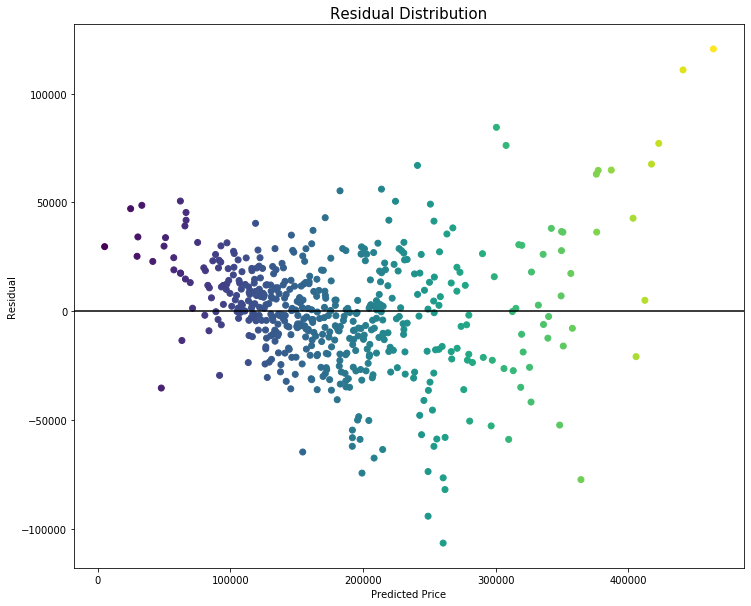

In [173]:
plt.figure(figsize=(12,10))
plt.scatter(preds, residuals, c=preds)
plt.title('Residual Distribution', size=15)
plt.xlabel('Predicted Price')
plt.ylabel('Residual')
plt.axhline(0, color='black');

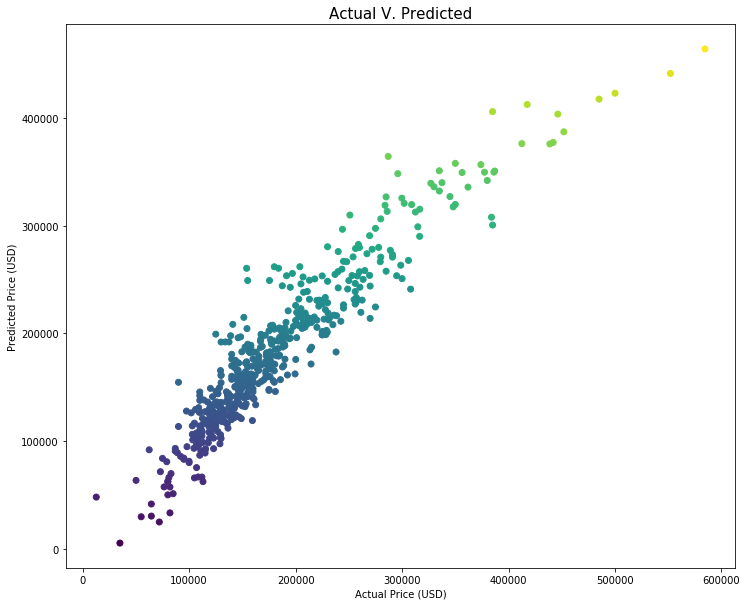

In [172]:
plt.figure(figsize=(12,10))
plt.scatter(y_test,preds, c=preds)
plt.title('Actual V. Predicted', size=15)
plt.xlabel('Actual Price (USD)')
plt.ylabel('Predicted Price (USD)');

In [161]:
lasso.coef_

array([ 9.05538045e+01, -9.79160084e+02, -1.70619616e+03,  6.44728565e+02,
        1.61562817e+03,  8.37543322e+02,  3.94750783e+03, -0.00000000e+00,
        5.13882162e+01, -2.11659403e+02,  3.26884808e+03,  2.77227509e+01,
       -1.76107206e+02, -1.96315188e+03, -1.75671276e+03, -8.53219038e+02,
       -2.05914119e+03, -3.13918001e+03,  2.94428195e+03,  1.40073086e+04,
       -2.32327068e+02, -2.65336154e+02, -9.43019273e+02, -1.76852124e+03,
        3.56013027e+03,  8.97085716e+03,  2.87487405e+03, -0.00000000e+00,
        1.71187397e+04,  1.87780314e+04,  2.86929803e+04,  2.27089201e+04,
        1.01267500e+04, -1.01562892e+03,  3.06846361e+03, -8.37438404e+03])

In [162]:
X1_train_sc

array([[-0.10599979, -0.05725983, -0.09257184, ..., -0.46570896,
        -0.08111071,  1.00261781],
       [-0.10599979, -0.05725983, -0.09257184, ...,  1.20690773,
        -0.08111071,  1.00261781],
       [-0.10599979, -0.05725983, -0.09257184, ..., -0.46570896,
        -0.08111071,  1.00261781],
       ...,
       [-0.10599979, -0.05725983, -0.09257184, ..., -0.46570896,
        -0.08111071,  1.00261781],
       [-0.10599979, -0.05725983, -0.09257184, ..., -0.46570896,
        -0.08111071, -0.99738903],
       [-0.10599979, -0.05725983, -0.09257184, ..., -0.46570896,
        -0.08111071, -0.99738903]])

In [163]:
lasso_coef = pd.Series(lasso.coef_, index = X1_train.columns)

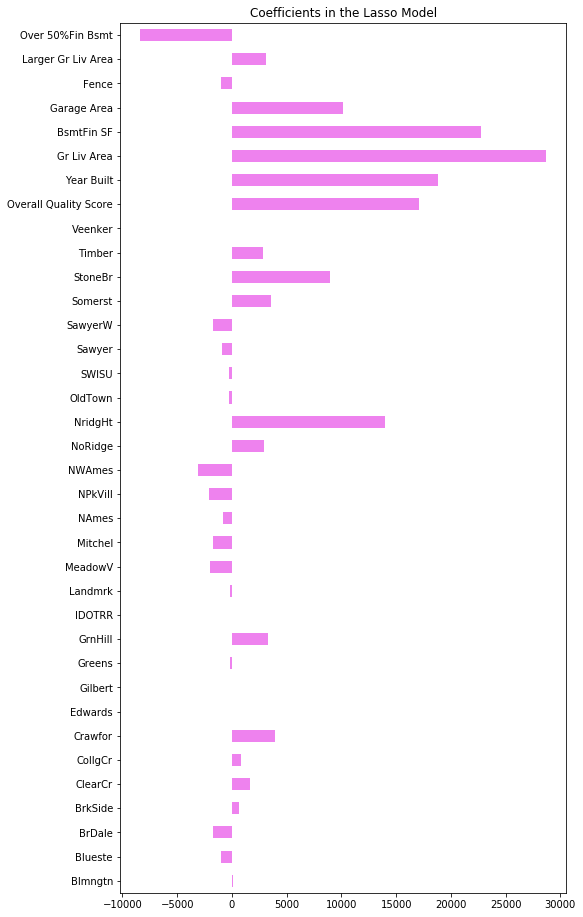

In [164]:
lasso_coef.plot(kind = "barh", color='violet', figsize=(8,16))
plt.title("Coefficients in the Lasso Model");